In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
datapath = f'../../src/datasets/01_basic_dataset_for_classification.csv'
df = pd.read_csv(datapath)
df.head()

,Unnamed: 0,data,label,object:name,object:instance,object:status,action:name,action:status,org:actor:name,org:actor:instance,org:passive:name,org:passive:instance
0,0,accept order,"['Automated activity', 'Physical activity', 'U...",order,NaN,NaN,accept,NaN,NaN,NaN,NaN,NaN
1,1,acquire equipment,"['Physical activity', 'User activity']",equipment,NaN,NaN,acquire,NaN,NaN,NaN,NaN,NaN
2,2,advertise post,"['Physical activity', 'User activity']",post,NaN,NaN,advertise,NaN,NaN,NaN,NaN,NaN
3,3,alert supervisor,"['Automated activity', 'Physical activity', 'U...",NaN,NaN,NaN,alert,NaN,NaN,NaN,supervisor,NaN
4,4,analyze defect,"['Physical activity', 'User activity']",defect,NaN,NaN,analyze,NaN,NaN,NaN,NaN,NaN


In [4]:
df=df[['data', 'label']]
df=df.rename(columns={'data':'text', 'label':'labels'})
df.head()

,text,labels
0,accept order,"['Automated activity', 'Physical activity', 'U..."
1,acquire equipment,"['Physical activity', 'User activity']"
2,advertise post,"['Physical activity', 'User activity']"
3,alert supervisor,"['Automated activity', 'Physical activity', 'U..."
4,analyze defect,"['Physical activity', 'User activity']"


<AxesSubplot:xlabel='labels'>

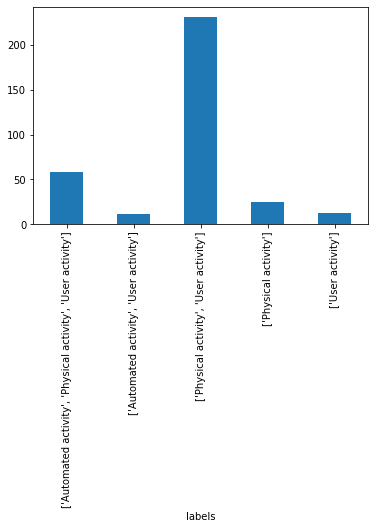

In [5]:
df.groupby(['labels']).size().plot.bar()


In [6]:
df.labels[0]

"['Automated activity', 'Physical activity', 'User activity']"

In [7]:
df.labels.value_counts()

['Physical activity', 'User activity']                          231
['Automated activity', 'Physical activity', 'User activity']     58
['Physical activity']                                            25
['User activity']                                                12
['Automated activity', 'User activity']                          11
Name: labels, dtype: int64

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')#("vinai/bertweet-base")#('bert-base-cased')
labels = {"['Physical activity', 'User activity']":0,
          "['Automated activity', 'Physical activity', 'User activity']":0,
          "['Physical activity']":1,
          "['User activity']":2,
          "['Automated activity', 'User activity']":0
          }

In [76]:
df['class']=df.labels.apply(lambda x: labels[x])

In [78]:
df['class'].value_counts()

0    300
1     25
2     12
Name: class, dtype: int64

In [79]:
sum(df['class'].value_counts())

337

In [83]:
(300/sum(df['class'].value_counts()))

0.8902077151335311

In [86]:
sum(df['class'].value_counts())/300

1.1233333333333333

In [87]:
sum(df['class'].value_counts())/25

13.48

In [88]:
sum(df['class'].value_counts())/12

28.083333333333332

In [84]:
(25/sum(df['class'].value_counts()))

0.07418397626112759

In [85]:
(12/sum(df['class'].value_counts()))

0.03560830860534125

In [113]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['labels']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 130, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [153]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('vinai/bertweet-base')#("vinai/bertweet-base")'bert-base-cased'
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()
        self.num_labels=3
        #self.weight=nn.CrossEntropyLoss()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [154]:
#train_label=train_label.type(torch.LongTensor)

In [187]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([28,13,1,4,3]))
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                train_label=train_label.type(torch.LongTensor)
                train_label = train_label.to(device)
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    val_label=val_label.type(torch.LongTensor)
                    val_label = val_label.to(device)
                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [188]:
def evaluate(model, test_data):
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              #print(output.argmax(dim=1))
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [189]:
import torch.nn as F

In [190]:
def get_evaluate(model, test_data):
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    #print(test_dataloader)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    predictions = []
    prediction_probs = []
    real_values = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            
            
            outputs = model(input_id, mask)

            _, preds = torch.max(outputs, dim=1)

            #probs = F.Softmax(outputs, dim=1)
            
            predictions.extend(preds)
            #prediction_probs.extend(probs)
            real_values.extend(test_label)
            
    predictions = torch.stack(predictions).cpu()
    #prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values
    

In [191]:
#np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.3*len(df)), int(.6*len(df))])

print(len(df_train),len(df_val), len(df_test))

101 101 135


In [192]:
EPOCHS = 6
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.10.output.LayerNorm.bias', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.5.attention.self.query.bias', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.6.attention.self.value.bias', 'roberta.encoder.layer.9.attention.output.dense.weight', 'roberta.encoder.layer.6.intermediate.dense.bias', 'roberta.encoder.layer.10.output.LayerNorm.weight', 'roberta.encoder.layer.4.output.dense.weight', 'roberta.encoder.layer.3.attention.self.query.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.LayerNorm.wei

Epochs: 1 | Train Loss:  0.440 | Train Accuracy:  0.782 | Val Loss:  0.180 | Val Accuracy:  0.901


  4%|▍         | 2/51 [00:00<00:02, 16.69it/s]

Epochs: 2 | Train Loss:  0.167 | Train Accuracy:  0.881 | Val Loss:  0.148 | Val Accuracy:  0.901


  4%|▍         | 2/51 [00:00<00:02, 16.57it/s]

Epochs: 3 | Train Loss:  0.157 | Train Accuracy:  0.881 | Val Loss:  0.143 | Val Accuracy:  0.901


  4%|▍         | 2/51 [00:00<00:03, 15.87it/s]

Epochs: 4 | Train Loss:  0.178 | Train Accuracy:  0.881 | Val Loss:  0.144 | Val Accuracy:  0.901


  4%|▍         | 2/51 [00:00<00:02, 17.07it/s]

Epochs: 5 | Train Loss:  0.165 | Train Accuracy:  0.881 | Val Loss:  0.138 | Val Accuracy:  0.901


100%|██████████| 51/51 [00:04<00:00, 12.49it/s]


Epochs: 6 | Train Loss:  0.145 | Train Accuracy:  0.881 | Val Loss:  0.129 | Val Accuracy:  0.901


In [177]:
evaluate(model, df_test)

Test Accuracy:  0.889


In [178]:
y_pred, y_pred_probs, y_test = get_evaluate(
  model,
  df_test
)

In [179]:
from sklearn.metrics import confusion_matrix, classification_report

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       120
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         7

    accuracy                           0.89       135
   macro avg       0.30      0.33      0.31       135
weighted avg       0.79      0.89      0.84       135



c:\Users\kiran.busch\OneDrive - Kühne Logistics University\project collab mannheim\git\env\rpa\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiran.busch\OneDrive - Kühne Logistics University\project collab mannheim\git\env\rpa\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kiran.busch\OneDrive - Kühne Logistics University\project collab mannheim\git\env\rpa\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [17]:
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru